# Lueschers Formula test in 3, 2, 1 dimensions

## Initialization

In [1]:
# Python modules
import itertools
import time

# Data management
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pylab as plt
import seaborn as sns

# Fitting
import scipy.optimize as opt

# Project modules
import luescher_nd.utilities as ut

### Parameters

Quantities will be expressed in units of [fm]. Energies are converted to inverse fermi using $\hbar c = 197.326$ MeV/fm.

In [2]:
HBARC = 197.326 # MeV / fm
M_NUCLEON = (938.27 + 939.57) / 2 / HBARC # in fm^{-1}

## Computation

### Intro

I tried to make the most simple test &mdash; implement a simple contact ingteraction Hamiltonian on a discrete 1-dimentisonal lattice in a finite volume with periodic boundary conditions to test the poles of the t-matrix (eigenstates of the system):

$$
    \rm{Re}\left(I_0(p, \Lambda)\right) - \frac{1}{C_0(\Lambda)} \overset{!}{=} 0 \, ,
$$

where $C_0(\Lambda)$ is the strength of the contact interaction which is fixed by the phase shift (or in terms of contact interactions only) the S-wave scattering length (in one dimension)

$$
    C_0(\Lambda) = - \frac{2}{\mu a_0}\, ,
$$

and $\mu = m_N / 2$ the reduced particle mass.
The momentum $p$ is related to an energy by $p = \sqrt{2 \mu |E|}$.

Casting the first equation into a continous one-dimensional finite volume results in

$$
    a_0 \overset{!}{=} \frac{L}{2 \pi^2} S_1 \left( \frac{\mu E L^2}{2 \pi^2} \right) \, ,
$$

and

$$
    S_1(x) =
    \begin{cases}
        - \pi \frac{\cot \left( \pi \sqrt{x} \right)}{\sqrt{x}} & x > 0 \\
        + \pi \frac{\coth \left(\pi \sqrt{-x}\right)}{\sqrt{-x}} & x < 0
    \end{cases} \, .
$$

### Workflow

To compute this relation in a discrete finite box, I execute the following workflow:

1. Fix the the lattice spacing and take a fixed value for $C_0( \Lambda)$,
2. Pick $L$ within a certain range and for each value of $L$:
    1. Compute the lowest eigenvalue $E_0$ of the Hamiltonian
    2. Evaluate $a_0(C_0( \Lambda)) \overset{!}{=} \frac{L}{2 \pi^2} S_1 \left( \frac{\mu E_0 L^2}{2 \pi^2} \right)$

### Difficulty

However, this procedure failed.

And the only difference between your prediction and my computation I am aware of is the finite lattice spacing

Even if the contact interaction used to pin down the phase shift does not depent on a ultra-violett cuttoff, it depends on the lattice spacing. 
One can see this when doing the following Gedankenexperiment:

If you want to compute the binding energy in discrete, one must solve the following equation (using the most simple 1-step derivative Hamiltonian)

$$
    - \frac{\psi(n+1) - 2\psi(n) + \psi(n-1)}{2 \mu \epsilon^2} 
    + c_{\epsilon} \sum_{n}\frac{\delta_{n, 0}}{\epsilon} \psi(n)
    =
    E_0 \psi(n) \, , \quad c_\epsilon < 0 \, .
$$

The solution to this equation is given by

$$
    \psi(n) = A \exp\left\{ - \lambda |n| \right\} \, 
$$

which results in the boundary conditions

$$
    c_{\epsilon}^2 = \frac{\gamma^2}{\mu^2} - \epsilon^2 \frac{\gamma^4}{4 \mu^2}
    \, , \quad
    c_{\epsilon} < 0
    \, , \quad
    \gamma = \sqrt{- 2 \mu E_0} \, .
$$

In other words, if you want to always find the same ground state solution to your Schrödinger equation, you must adjust your contact interaction strenght to the lattice spacing:

$$
    c_{\epsilon}(\Lambda, \epsilon) = C_0(\Lambda) \sqrt{ 1 +  \frac{\epsilon^2 \gamma^2}{4 }}
    \, ,\quad
    C_0(\Lambda) = - \frac{\gamma}{\mu}
    \, .
$$

However, since $c_{\epsilon}(\Lambda, \epsilon)$ is used for computing the in general unknown energy, the procedure works quite differently:

#### Adjusted workflow

1. Fix $c_{\epsilon}(\Lambda, \epsilon)$
2. Compute the ground state energy $E_0 = f(\epsilon, c_{\epsilon})$
3. Compute the continuum interaction strength $C_0(\Lambda) = f(\epsilon, c_{\epsilon}, E_0)$
4. Evaluate $a_0(C_0( \Lambda)) \overset{!}{=} \frac{L}{2 \pi^2} S_1 \left( \frac{\mu E_0 L^2}{2 \pi^2} \right)$

### Visulalize lattice spacing dependence

Since the above relation is known analytically, we can reverse the process for demonstration purposes:

1. Fix the resulting binding energy of the computation $E_0$
2. Analytically fix the input contact interaction strength $c_{\epsilon}$ to obtain $E_0$

In [3]:
L = 20. # in fm -- fixed for no finite volume differences
c0 = -1.0 # in fm^0 -- fixed to fix energy in continuum
mu = M_NUCLEON / 2
gamma0 = - c0 * mu
E0 = - gamma0**2 / 2 / mu # in fm^{-1} -- fixed

lattice_spacings = np.linspace(1.e-1, 4.0, 101)[::-1]

# analytically comput c_epsilon
c_epsilons = c0 * np.sqrt(1 + gamma0 ** 2 * lattice_spacings ** 2 / 4)

energies = []

for epsilon, c_lat in zip(lattice_spacings, c_epsilons):

    n1d_max = int(L / epsilon)

    solver = ut.Solver(
        n1d_max=n1d_max,
        ndim_max=1,
        lattice_spacing=epsilon,
    )

    energies.append(solver.get_ground_state(c_lat))

energies = np.array(energies)

Because of this adjustment of the lattice spacing, the extracted energy is independent of the lattice spacing. 

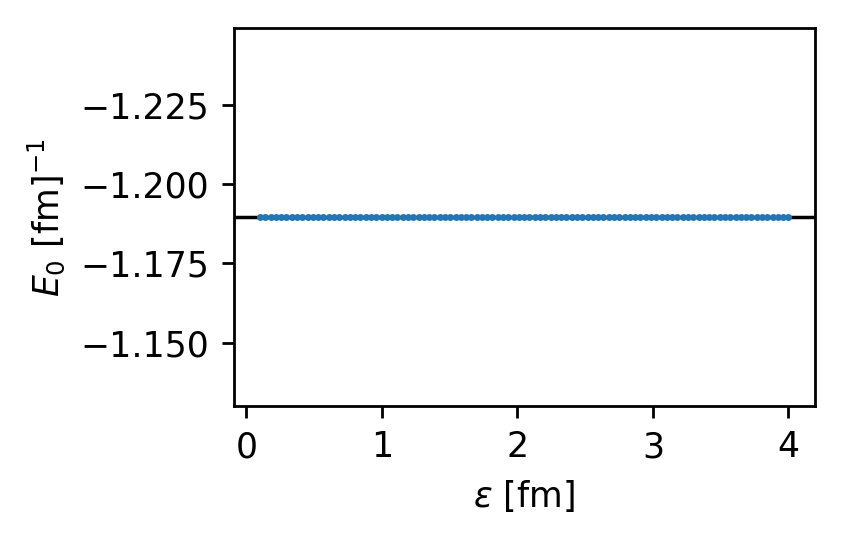

In [4]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=250)

ax.plot(lattice_spacings, energies, ".", ms=2, zorder=2)
ax.axhline(E0, ls="-", c="black", lw=1, zorder=1)

ax.set_ylim(E0 * 0.95, E0 * 1.05)
ax.set_ylabel("$E_0$ [fm]$^{-1}$")
ax.set_xlabel("$\epsilon$ [fm]")

plt.show(fig)

### Show that it works now...

In [5]:
def s1(x):
    """S1(x) as defined in equation (34) of your notes (for also negative x).
    """
    if x > 0:
        return - np.pi / np.tan(np.pi * np.sqrt(x)) / np.sqrt(x)
    else:
        return np.pi / np.tanh(np.pi * np.sqrt(-x)) / np.sqrt(-x)

In [6]:
p = np.sqrt(-E0 * mu * 2)

a0_analytic = -2 / (mu * 2) / c0
a0_lattice = []
a0_analytic_not_adjusted = []

for epsilon, c_lat in zip(lattice_spacings, c_epsilons):

    L = n1d_max * epsilon
    x = (p * L / 2 / np.pi) ** 2

    a0_lattice.append(s1(-x) * L / 2 / np.pi ** 2)
    a0_analytic_not_adjusted.append(-2 / (mu * 2) / c_lat)
    
a0_lattice = np.array(a0_lattice)
a0_analytic_not_adjusted = np.array(a0_analytic_not_adjusted)

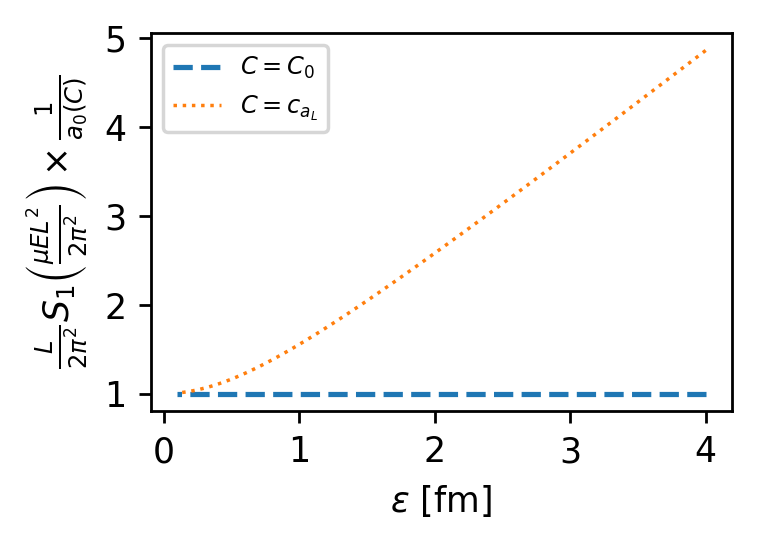

In [7]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=250)

ax.plot(lattice_spacings, a0_lattice / a0_analytic, "--", ms=3, zorder=2, label="$C = C_0$")
ax.plot(
    lattice_spacings,
    a0_lattice / a0_analytic_not_adjusted,
    ":",
    lw=1,
    zorder=2,
    label="$C = c_{a_L}$",
)

ax.set_ylabel(
    r"$\frac{L}{2 \pi^2} S_1 \left( \frac{\mu E L^2}{2 \pi^2} \right) \times \frac{1}{a_0(C)}$"
)
ax.set_xlabel("$\epsilon$ [fm]")

ax.legend(fontsize="x-small")

plt.show(fig)

## Probing the phase space

In [8]:
c0 = -1.0 # in fm^0 -- fixed to fix energy in continuum
mu = M_NUCLEON / 2
gamma0 = - c0 * mu
E0 = - gamma0**2 / 2 / mu # in fm^{-1} -- fixed
epsilon = 1.0 # in fm -- fixed

# analytically comput c_epsilon
c_epsilon = c0 * np.sqrt(1 + gamma0 ** 2 * epsilon ** 2 / 4)

a0_analytic = -2 / (mu * 2) / c0

energies = []

n1d_range = np.arange(4, 40)

for n1d_max in n1d_range:

    solver = ut.Solver(
        n1d_max=n1d_max,
        ndim_max=1,
        lattice_spacing=epsilon,
    )

    energies.append(solver.get_ground_state(c_epsilon))

energies = np.array(energies)

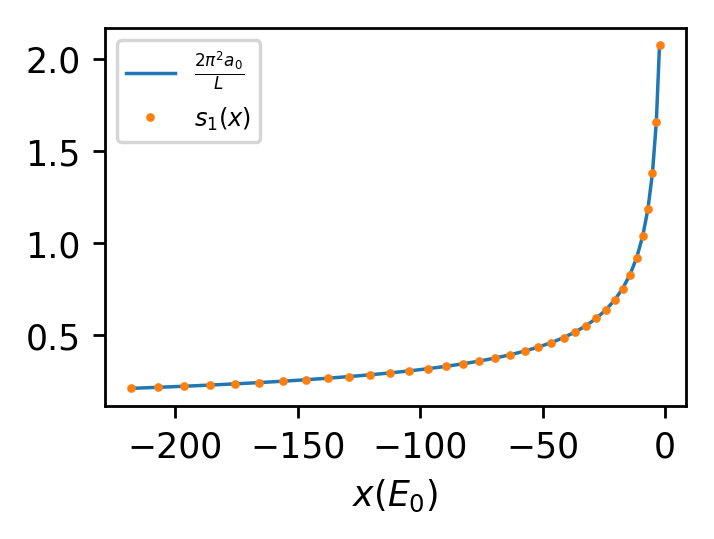

In [9]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=250)

Ls = n1d_range * epsilon
xs = mu * energies * Ls**2 / 2 / np.pi**2

ax.plot(xs, a0_analytic*2*np.pi**2/Ls, "-", lw=1, zorder=0, label=r"$\frac{2 \pi^2 a_0}{L}$")
ax.plot(xs, [s1(x) for x in xs], ".", ms=3, zorder=2, label=r"$s_1(x)$")

ax.set_xlabel("$x(E_0)$")

ax.legend(fontsize="x-small")

plt.show(fig)

## ToDO:

* Higher dimensions
* Positive $c_0$